In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
df=pd.read_csv('TCS1.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-27,122.800003,122.800003,119.820000,120.332497,88.088272,30646000.0
1,2004-08-30,121.237503,123.750000,120.625000,123.345001,90.293549,24465208.0
2,2004-08-31,123.312500,123.750000,122.000000,123.512497,90.416122,21194656.0
3,2004-09-01,123.750000,124.375000,122.949997,123.487503,90.397820,19935544.0
4,2004-09-02,123.737503,125.574997,123.250000,124.207497,90.924896,21356352.0


### Data Exploration

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4494 entries, 0 to 4493
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4494 non-null   object 
 1   Open       4486 non-null   float64
 2   High       4486 non-null   float64
 3   Low        4486 non-null   float64
 4   Close      4486 non-null   float64
 5   Adj Close  4486 non-null   float64
 6   Volume     4486 non-null   float64
dtypes: float64(6), object(1)
memory usage: 245.9+ KB


In [4]:
df.isnull().sum()

Date         0
Open         8
High         8
Low          8
Close        8
Adj Close    8
Volume       8
dtype: int64

In [5]:
df.duplicated().sum()

0

In [6]:
df.dropna(inplace=True)

### EDA

<Axes: >

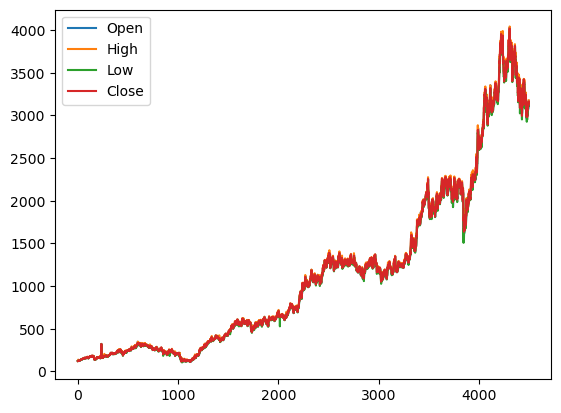

In [7]:
df.drop(['Volume','Adj Close'],axis=1).plot(kind='line')

<Axes: >

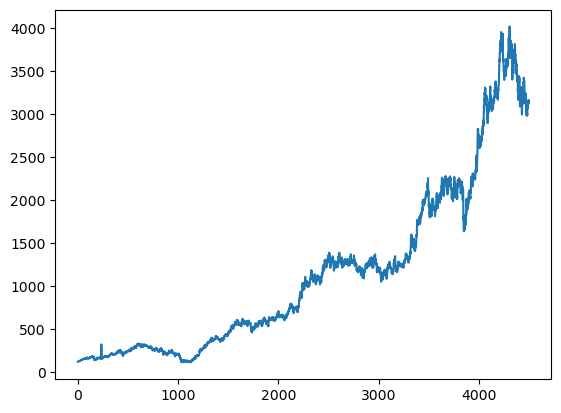

In [8]:
df['Close'].plot(kind='line')

In [9]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4486.000000,4486.000000,4486.000000,4486.000000,4486.000000,4.486000e+03
mean,1146.182768,1158.538059,1132.825428,1145.521462,1049.456965,3.620596e+06
std,994.070086,1003.010607,984.043404,993.346465,992.062558,3.162368e+06
min,112.000000,116.112503,103.837502,111.550003,86.565590,0.000000e+00
25%,290.693748,295.300010,285.931259,290.275009,219.902748,1.942489e+06
50%,977.450012,995.000000,970.250000,981.337524,820.627839,2.804749e+06
75%,1564.774963,1597.287476,1548.662537,1576.781219,1443.631561,4.297410e+06
max,4033.949951,4043.000000,3980.000000,4019.149902,3964.502686,8.806715e+07


C:\Users\vamsh\AppData\Local\Temp\ipykernel_7596\361330810.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


(6.5, -0.5)

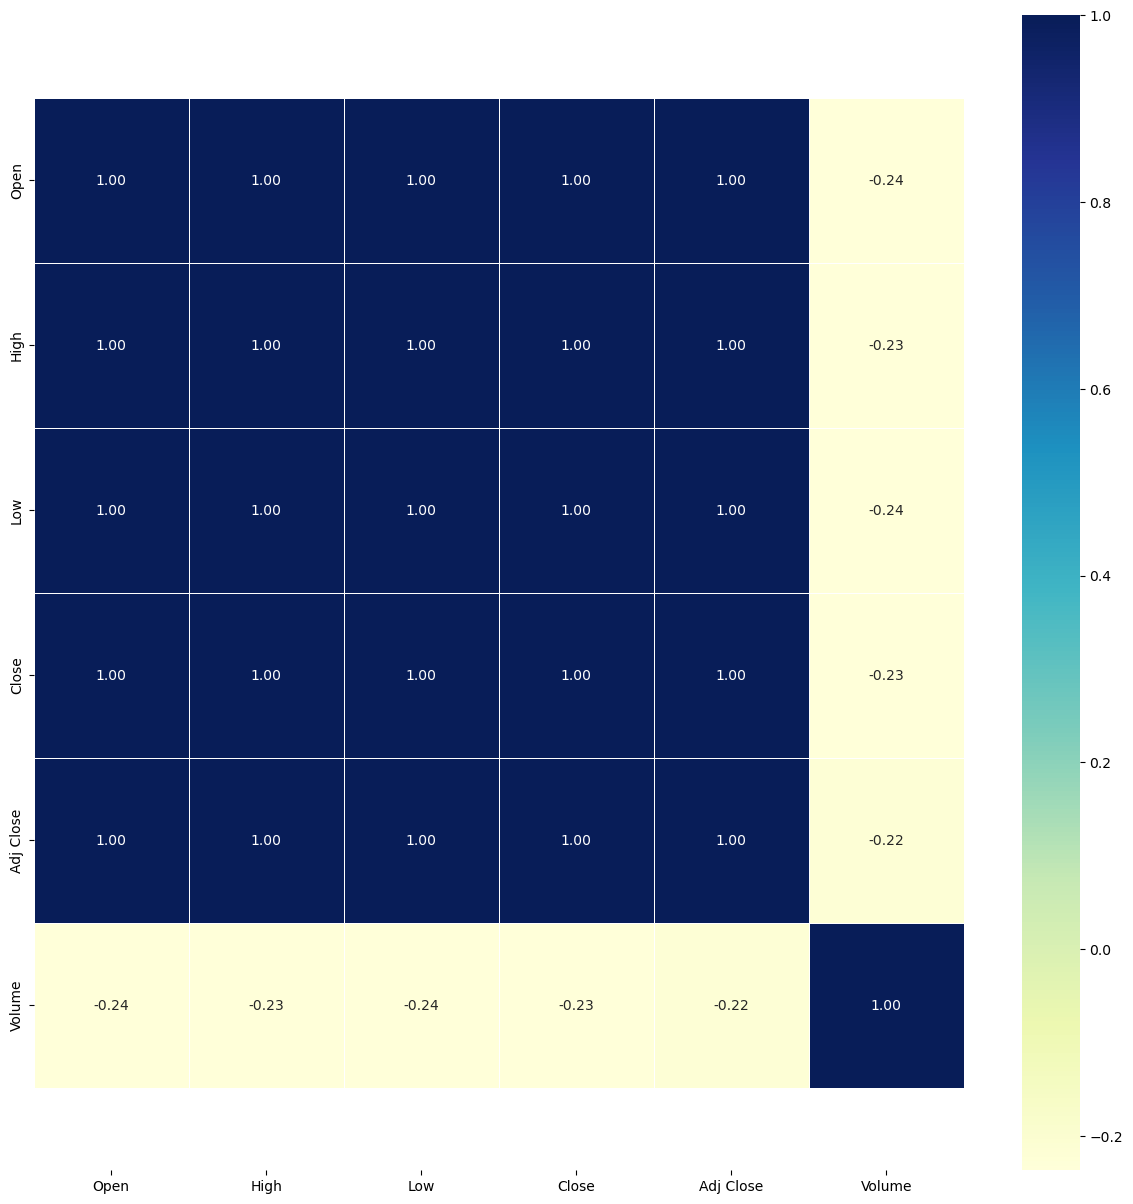

In [10]:
import seaborn as sns
corr_matrix = df.corr()
fig, ax = plt.subplots(figsize=(15, 15))
ax = sns.heatmap(corr_matrix,
                 annot=True,
                 linewidths=0.5,
                 fmt=".2f",
                 cmap="YlGnBu");
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

### Data Preprocessing

In [11]:
df['Date']=pd.to_datetime(df['Date']) # convert object to datetime datatype

In [12]:
close_prices=df['Close'].values.reshape(-1,1)

### Scaling the Features

In [13]:
from sklearn.preprocessing import MinMaxScaler
# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
close_prices_scaled = scaler.fit_transform(close_prices)


### Preparing Data For LSTM MODEL

In [14]:
# Prepare the data for LSTM
def prepare_data(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)


In [15]:
time_steps = 100  # Number of days to look back
X, y = prepare_data(close_prices_scaled, time_steps)


In [16]:
# Reshape data for LSTM (samples, time_steps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

In [17]:
# Split the data into training and testing sets
split = int(0.8 * len(X))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]


In [18]:
print(X_train.shape), print(y_train.shape)

(3508, 100, 1)
(3508,)


(None, None)

In [19]:
print(X_test.shape), print(y_test.shape)

(878, 100, 1)
(878,)


(None, None)

### Building LSTM MODEL

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [21]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [23]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


In [24]:
# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32)


Epoch 1/50
110/110 [==============================] - 47s 301ms/step - loss: 0.0020
Epoch 2/50
110/110 [==============================] - 32s 287ms/step - loss: 5.4282e-04
Epoch 3/50
110/110 [==============================] - 30s 275ms/step - loss: 5.5677e-04
Epoch 4/50
110/110 [==============================] - 31s 284ms/step - loss: 4.4356e-04
Epoch 5/50
110/110 [==============================] - 29s 261ms/step - loss: 4.1143e-04
Epoch 6/50
110/110 [==============================] - 31s 286ms/step - loss: 4.2010e-04
Epoch 7/50
110/110 [==============================] - 32s 295ms/step - loss: 3.5326e-04
Epoch 8/50
110/110 [==============================] - 32s 286ms/step - loss: 3.5461e-04
Epoch 9/50
110/110 [==============================] - 31s 286ms/step - loss: 3.0807e-04
Epoch 10/50
110/110 [==============================] - 31s 280ms/step - loss: 2.9527e-04
Epoch 11/50
110/110 [==============================] - 29s 266ms/step - loss: 2.7874e-04
Epoch 12/50
110/110 [=============

### Stock price for next 3days

In [25]:
predictions = []
current_batch = X_test[-1].reshape((1, time_steps, 1))

for i in range(3):
    predicted_price = model.predict(current_batch)[0][0]
    predictions.append(predicted_price)
    # Reshape predicted_price to match the shape of current_batch
    predicted_price_reshaped = np.array([[[predicted_price]]])
    current_batch = np.append(current_batch[:, 1:, :], predicted_price_reshaped, axis=1)

# Inverse transform the predictions to get actual prices
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Print the predicted prices
print("Predicted stock prices for the next 3 days:")
for i, price in enumerate(predictions):
    print(f"Day {i+1}: {price[0]}")


    

1/1 [==============================] - 0s 80ms/step
Predicted stock prices for the next 3 days:
Day 1: 3258.879150390625
Day 2: 3281.150634765625
Day 3: 3313.958251953125


28/28 [==============================] - 2s 81ms/step


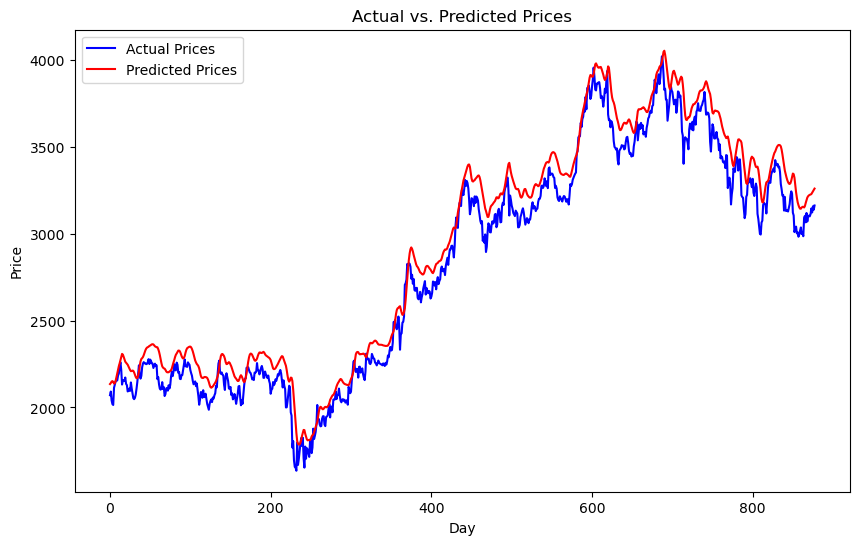

In [26]:
import matplotlib.pyplot as plt

# Predict the entire test set
predicted_prices = model.predict(X_test)

# Inverse transform the test and predicted data for plotting
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))
predicted_prices = scaler.inverse_transform(predicted_prices)

# Plot actual vs. predicted prices for the entire test set
plt.figure(figsize=(10, 6))
plt.plot(actual_prices, color='blue', label='Actual Prices')
plt.plot(predicted_prices, color='red', label='Predicted Prices')
plt.title('Actual vs. Predicted Prices')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.show()


In [30]:
model.evaluate(X_test,y_test)

28/28 [==============================] - 7s 81ms/step - loss: 0.0011


0.001084312330931425

1/1 [==============================] - 0s 79ms/step


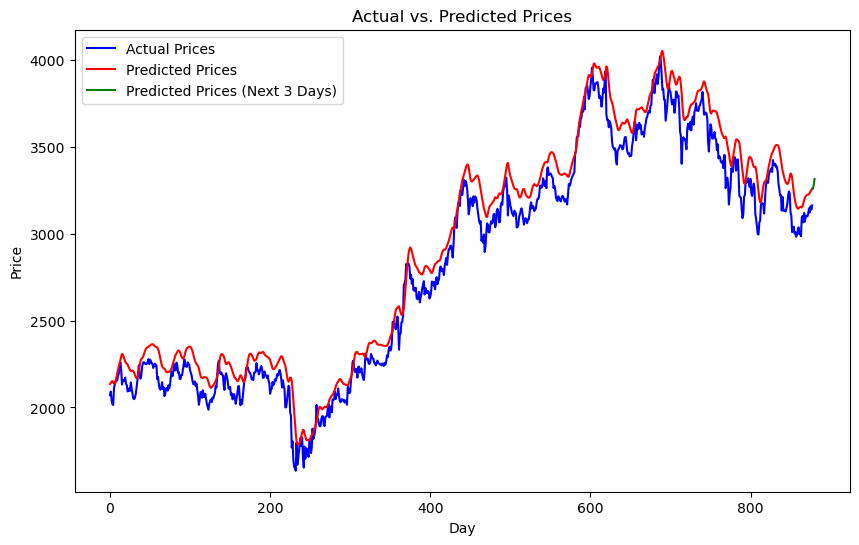

In [31]:
import matplotlib.pyplot as plt

# Predict the entire test set
predicted_prices = model.predict(X_test)

# Inverse transform the test and predicted data for plotting
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))
predicted_prices = scaler.inverse_transform(predicted_prices)

# Plot actual vs. predicted prices for the entire test set
plt.figure(figsize=(10, 6))
plt.plot(actual_prices, color='blue', label='Actual Prices')
plt.plot(predicted_prices, color='red', label='Predicted Prices')
plt.title('Actual vs. Predicted Prices')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()

# Predict the next 3 days' prices
predictions = []
current_batch = X_test[-1].reshape((1, time_steps, 1))

for i in range(3):
    predicted_price = model.predict(current_batch)[0][0]
    predictions.append(predicted_price)
    # Reshape predicted_price to match the shape of current_batch
    predicted_price_reshaped = np.array([[[predicted_price]]])
    current_batch = np.append(current_batch[:, 1:, :], predicted_price_reshaped, axis=1)

# Inverse transform the predictions to get actual prices
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Plot predicted prices for the next 3 days
plt.plot(range(len(actual_prices), len(actual_prices) + len(predictions)), predictions, color='green', label='Predicted Prices (Next 3 Days)')

plt.title('Actual vs. Predicted Prices')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.show()


array([0.8518272])